In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from ase import Atoms  # 3D mouse clickable funky visualization
import ase.visualize
import networkx as nx # for cycle detection

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import os
OUTPUT_PATH = "./preprocessed/"

In [16]:
train = pd.read_csv("./preprocessed/train_df.csv")
test = pd.read_csv("./preprocessed/test_df.csv")
structures = pd.read_csv("./champs-scalar-coupling/structures.csv")

In [17]:
def view3d_molecule(name):
    m = structures[structures.molecule_name == name]
    positions = m[['x','y','z']].values
    # pip install ase
    return ase.visualize.view(Atoms(positions=positions, symbols=m.atom.values), 
                              viewer="x3d") 
cpk = { 
    'C': ("black", 2),
    'H': ("white", 1),
    'O': ("red",   2),
    'N': ("blue", 2),
    'F': ("green", 2) }

bond_colors = {'1.0':'black', '1.5':'darkgreen', '2.0':'green', '3.0':'red'}

def bond_type_to_pair(bond_type):
    return bond_type[3:]
def bond_type_to_n(bond_type):
    return bond_type[0:3]

def plot_molecule(name, ax=None, bonds=None, charges=None, elev=0, azim=-60):
    """bonds = if provided add bonds display from the bond table dataset in https://www.kaggle.com/asauve/predicting-molecular-properties-bonds
    elev = 3D elevation angle [degree] for the molecule view
    azim = 3D azimut angle [degree]
    """
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
    if (elev != 0) or (azim != -60):
        ax.view_init(elev=elev, azim=azim)
    
    # atoms location
    m = structures[structures.molecule_name == name].sort_values(by='atom_index')
    if (charges is not None):
        charges = charges[charges.molecule_name == name].sort_values(by='atom_index')
        if len(charges) != len(m):
            print(f"Warning bad charges data for molecule {name}")
    
    # formula
    acount = {a : 0 for a in cpk}
    for a in m.atom:
        acount[a] += 1
    formula = ""
    for a in acount:
        if acount[a] == 1:
            formula += a
        elif acount[a] > 1:
            formula += "%s_{%d}" % (a, acount[a])

    ax.set_title(f'{name} ${formula}$')
    
    # display couplings (coupling is not molecular bonds!)
    couples = train[train.molecule_name == name][['atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
    for c in couples.itertuples():
        m0 = m[m.atom_index == c.atom_index_0]
        m1 = m[m.atom_index == c.atom_index_1]
        ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)],
               linestyle = ['', '-', '--', 'dotted'][int(c.type[0])],
               color     = ['', 'black', 'green', 'red' ][int(c.type[0])],
               linewidth = abs(float(c.scalar_coupling_constant))/5,
               alpha=0.2), 
    if bonds is not None:
        for b in bonds[bonds.molecule_name == name].itertuples():
            m0 = m[m.atom_index == b.atom_index_0]
            m1 = m[m.atom_index == b.atom_index_1]
            ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)], 'black', 
                    linewidth=2*float(b.nbond),
                    color=bond_colors[bond_type_to_n(b.bond_type)])
            
    # display atoms
    ax.scatter(m.x, m.y, m.z, c=[cpk[a][0] for a in m.atom], s=[100*cpk[a][1] for a in m.atom], edgecolor='black')
        
    # display atom index and charges
    for row in m.itertuples():
        x = float(row.x) - 0.15 if row.x > ax.get_xlim()[0] + 0.15 else row.x
        y = float(row.y) - 0.15 if row.y > ax.get_ylim()[0] + 0.15 else row.y
        z = float(row.z) - 0.15 if row.z > ax.get_zlim()[0] + 0.15 else row.z
        ax.text(x, y, z, str(row.atom_index), color='darkviolet')
        if charges is not None:
            ch = float(charges[charges.atom_index == row.atom_index].charge)
            if ch != 0:
                x = float(row.x) + 0.15 if row.x < ax.get_xlim()[1] - 0.15 else row.x
                y = float(row.y) + 0.15 if row.y > ax.get_ylim()[1] - 0.15 else row.y
                z = float(row.z) + 0.15 if row.z < ax.get_zlim()[1] - 0.15 else row.z
                ax.text(x, y, z, f"{ch:+.1f}", color='orangered' if ch > 0 else 'blue',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, 
                                  edgecolor='black'))
#plot_molecule("dsgdb9nsd_000140", bonds=train_bonds, charges=train_charges)

In [18]:
from scipy.spatial import cKDTree as KDTree
from tqdm.notebook import tqdm


# "usual" valence of atoms
VALENCE_MAX = { 'C': 4, 'H' : 1, 'N' : 4, 'O' : 2, 'F': 1 }
VALENCE_STD = { 'C': 4, 'H' : 1, 'N' : 3, 'O' : 2, 'F': 1 }

# expected distances in [A] for covalence 1 bond
BOND_DIST_C1 = { 'C' : 0.77, 'H' : 0.38, 'N' : 0.75, 'O' : 0.73, 'F' : 0.71 }

# order used for finding bonds by atom type
BOND_ORDER = { 'H' : 0, 'F' : 0, 'O' : 1, 'N' : 2, 'C' : 3}

def add_bond(n_avail, nbond, a0, a1, d1=None):
    key = tuple(sorted((a0, a1)))
    if key in nbond:
        nbond[key][0] += 1.0
    elif d1 is not None:
        nbond[key] = [1.0, d1]
    else:
        raise Exception(f"{a0},{a1} added after phase 1")
    n_avail[a0] -= 1
    n_avail[a1] -= 1
    #display(f"{a0},{a1} => {n_avail}, {nbond}")

def get_bonded_atoms(atoms, nbond, i):
    """returns: [sorted atoms list], [sorted atom index] )"""
    bonded = []
    for (a0, a1), (n, _) in nbond.items():
        if a0 == i:
            bonded.append((a1, atoms[a1]))
        elif a1 == i:
            bonded.append((a0, atoms[a0]))
    bonded = sorted(bonded, key=lambda b: b[1])
    return "".join([b[1] for b in bonded]), [b[0] for b in bonded]


def search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, a0, 
                 connect_once=True, VALENCE=VALENCE_STD):
    atom0 = atoms[a0]
    if n_avail[a0] == 0:
        return

    # select closest atoms ORDERED BY DISTANCE: closest first
    # note: the first answer is the atom itself and must be removed
    next_dist, next_i = kdt.query(coords[a0], min(1+VALENCE[atom0], len(atoms)))
    next_dist = next_dist[1:]; # remove a0 from list
    next_i = next_i[1:]

    # for each #VALENCE closest atoms
    found = False
    for d1,a1 in zip(next_dist, next_i):
        if connect_once and (a1 in connected[a0]):
            continue  # enforce 1-bond only in STEP 1
        atom1 = atoms[a1]
        predicted_bond = BOND_DIST_C1[atom0] + BOND_DIST_C1[atom1]
        if abs(d1 / predicted_bond) < 1.2: # keep only atoms in the 20% expected distance or closer
            if n_avail[a1] > 0:
                add_bond(n_avail, nbond, a0, a1, d1)
                connected[a0][a1] = 1
                connected[a1][a0] = 1
                if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                    isleaf[a0] = 1
                    isleaf[a1] = 1
                found = True
                #print("leaF/Trunk & avail: "+ ", ".join([f"{i}:{atoms[i]}={leaflabel[isleaf[i]]}{n_avail[i]}"
                #                 for i in ordered_atoms_index]))

        else:
            #print(f"-- match failure in molecule_name={name} {a0}:{atom0}-{a1}:{atoms[a1]}={d1} predicted={predicted_bond}")
            pass
    return found
    
def compute_bonds(structures, molecules):
    out_name = []; out_a0 = []; out_a1 = []; out_n = []; out_dist = []; out_error = []; out_type = []
    cycle_name = []; cycle_index = []; cycle_seq = [];  cycle_atom_index = []
    charge_name = []; charge_atom_index = []; charge_value = [];
    for imol,name in tqdm(list(enumerate(molecules))):
        molecule = structures.loc[name ]
        error    = 0
        atoms    = molecule.atom.values
        atoms_idx= molecule.atom_index.values
        
        n_avail  = np.asarray([VALENCE_STD[a] for a in atoms])
        n_charge = np.zeros(len(atoms), dtype=np.float16)
        isleaf   = np.zeros(len(atoms), dtype=bool) # is the atom in the leafs of connection tree?
        coords   = molecule[['x', 'y', 'z']].values
        kdt = KDTree(coords) # use an optimized structure for closest match query
        nbond = {}
        connected = { i:{} for i in atoms_idx}
        
        # select Hydrogen first to avoid butadyne-like ordering failures (molecule_name=dsgdb9nsd_000023)
        ordered_atoms_index = list(atoms_idx)
        ordered_atoms_index.sort(key = lambda i: BOND_ORDER[atoms[i]])
        ordered_atoms_index = np.asarray(ordered_atoms_index)
        
        # STEP 1: 1-bond connect each atom with closest match
        #         only one bond for each atom pair is done in step 1
        for a0 in ordered_atoms_index:
            search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx, a0,
                         connect_once=True, VALENCE=VALENCE_STD)
     
        # STEP 2: greedy connect n-bonds, progressing from leafs of connection tree
        while (((n_avail > 0).sum() > 0) and isleaf).sum() > 0:
            progress = False
            for a0 in ordered_atoms_index:
                #print("leaF/Trunk & avail: " + ", ".join([f"{i}:{atoms[i]}={leaflabel[leaf[i]]}{n_avail[i]}"
                #                                          for i in ordered_atoms_index]))
                if (n_avail[a0] > 0) and isleaf[a0]:
                    for a1 in connected[a0]:
                        if (n_avail[a0] > 0) and (n_avail[a1] > 0):
                            add_bond(n_avail, nbond, a0, a1) 
                            progress = True
                            if (n_avail[a0] == 0) or (n_avail[a1] == 0):
                                isleaf[a0] = 1
                                isleaf[a1] = 1
            if not progress:
                break
        
        # gather remaining multiple bonds
        if n_avail.sum() > 0:
            for key in nbond.keys():
                a0, a1 = key
                while (n_avail[a0] > 0) and (n_avail[a1] > 0):
                    add_bond(n_avail, nbond, a0, a1)
    
        # STEP 3: search for known ionized radicals
        if n_avail.sum() > 0:
            for (i,a) in zip(atoms_idx, atoms):
                if a == 'N':
                    # NH3+
                    bonded_str, bonded_idx = get_bonded_atoms(atoms, nbond, i)
                    if (bonded_str == "HHH") and (n_avail[i] == 0):
                        # add a valence unit and search a dangling bond nearby
                        n_avail[i] += 1; n_charge[i] += 1
                        if search_bonds(kdt, n_avail, nbond, connected, isleaf, coords, atoms, atoms_idx,
                                        i, connect_once=False, VALENCE=VALENCE_MAX):
                            print(f"++ NH3+ found for {name} atom_index={i}")
                        else:
                            print(f"** NH3+ bonding failure for {name} atom_index={i}")
                            
                elif (a == 'O') and (n_avail[i] == 1):
                    # COO-
                    bonded_str, bonded_idx = get_bonded_atoms(atoms, nbond, i)
                    if bonded_str == "C":
                        C_i = bonded_idx[0]
                        C_bonded_str, C_bonded_idx = get_bonded_atoms(atoms, nbond, C_i)
                        if ("OO" in C_bonded_str):
                            has_2CO = False 
                            #print (C_bonded_str, C_bonded_idx, nbond, name)
                            for a1, i1 in zip(C_bonded_str, C_bonded_idx):
                                key = tuple(sorted((C_i, i1)))
                                if (a1 == 'O') and  (nbond[key][0] == 2):
                                    has_2CO = True
                            if (len(C_bonded_idx) == 3) and has_2CO:
                                # found carboxyle!
                                n_avail[i] -= 1
                                print(f"**  COO- found for {name} C_atom_index={C_i}")
                                for a1, i1 in zip(C_bonded_str, C_bonded_idx):
                                    if a1 == 'O':
                                        n_charge[i1] = -0.5
                                        key = tuple(sorted((C_i, i1)))
                                        nbond[key][0] = 1.5                    
                                    
        # detect cycles : algo complexity in O(m^2 * n)
        #    paper : https://link.springer.com/article/10.1007/s00453-007-9064-z
        #    nx doc: https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.cycles.minimum_cycle_basis.html
        graph = nx.Graph([bond for bond in nbond.keys()])
        unordered_cycles = nx.minimum_cycle_basis(graph)
        
        # index atoms by their sequential order in the cycle: i.e follow bonds
        # Note: this code can be written in a much cleaner way!
        if len(unordered_cycles) > 0:
            for icycle, c in enumerate(unordered_cycles):
                available = {i:1 for i in c}
                a0 = c[0]
                cycle = [ a0 ]
                del(available[a0])
                for index in range(1, len(c)):
                    # get atoms bonded to a0
                    bonded = [ b for b in nbond.keys() if a0 in b ]
                    bonded = list(map(lambda b: b[0] if b[1] == a0 else b[1], bonded))
                    
                    # get next atom and remove it from cycle
                    assert(len(bonded) > 0)
                    found = False
                    for a1 in bonded:
                        if (a1 in bonded) and (a1 in available):
                            cycle.append(a1)
                            del(available[a1])
                            a0 = a1
                            found = True
                            break
                    assert(found)
                    
                # and add cycles found to the cycle dataframe lists
                cycle_name.extend([name] * len(cycle))
                cycle_index.extend([icycle] * len(cycle))
                cycle_seq.extend(np.arange(len(cycle)))
                cycle_atom_index.extend(cycle)
        
        # display info on failed molecules
        if n_avail.sum() > 0:
            error = 1
            print(f"   Remaining bondings={n_avail.sum()} for molecule_name={name}, atoms: " +
                  ", ".join([f"{i}:{atoms[i]}" for i in atoms_idx if n_avail[i] > 0]))

        # inputs for DataFrame bonds
        for (a0, a1), (n, dist) in nbond.items():
            # append to python lists which is 7x faster than toa pd.DataFrame
            out_name.append(name); out_a0.append(a0); out_a1.append(a1); out_n.append(n)
            out_dist.append(dist); out_error.append(error)
            out_type.append(f"{n:0.1f}" + "".join(sorted(f"{atoms[a0]}{atoms[a1]}")) )
    
        # inputs for DataFrame charges
        charge_name.extend(        [name] * len(atoms) )
        charge_atom_index.extend(  molecule.atom_index.values )
        charge_value.extend(       n_charge )
        
    bonds = pd.DataFrame({'molecule_name':out_name, 'atom_index_0':out_a0,'atom_index_1':out_a1, 'nbond':out_n, 
                          'L2dist':out_dist, 'error':out_error, 'bond_type':out_type})
    charges = pd.DataFrame({'molecule_name':charge_name, 'atom_index':charge_atom_index, 
                            'charge': charge_value})
    cycles = pd.DataFrame({'molecule_name' : cycle_name, 'cycle_index' : cycle_index, 
                           'cycle_seq' : cycle_seq, 'atom_index' : cycle_atom_index})
    return bonds, charges, cycles

In [19]:
train_bonds, train_charges , train_cycles = \
    compute_bonds(structures.set_index('molecule_name'), 
                  train.molecule_name.unique())
#debug_name = "dsgdb9nsd_000202"
#train_bonds, train_charges, _ = compute_bonds(structures.set_index('molecule_name'), 
#                                           [ debug_name ])
#plot_molecule(debug_name, bonds=train_bonds, charges=train_charges)
#view3d_molecule(debug_name)

  0%|          | 0/68009 [00:00<?, ?it/s]

   Remaining bondings=2 for molecule_name=dsgdb9nsd_000208, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000909, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000911, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000912, atoms: 0:O, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000974, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000982, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001005, atoms: 0:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001006, atoms: 0:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001012, atoms: 0:N, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001013, atoms: 0:N, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001014, atoms: 0:N, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001047, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001050, atoms: 2:C, 5:C
   Remaining

In [20]:
test_bonds, test_charges, test_cycles = \
    compute_bonds(structures.set_index('molecule_name'), 
                  test.molecule_name.unique())

  0%|          | 0/17003 [00:00<?, ?it/s]

   Remaining bondings=2 for molecule_name=dsgdb9nsd_000204, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000731, atoms: 2:C, 4:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000761, atoms: 2:C, 4:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000854, atoms: 2:C, 4:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_000968, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_001046, atoms: 2:C, 5:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_002869, atoms: 0:C, 3:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_003632, atoms: 0:C, 5:N
   Remaining bondings=2 for molecule_name=dsgdb9nsd_004273, atoms: 4:O, 6:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_004302, atoms: 4:O, 6:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_004313, atoms: 4:O, 6:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_004325, atoms: 2:C, 6:C
   Remaining bondings=2 for molecule_name=dsgdb9nsd_004518, atoms: 2:C, 5:C
   Remaining

In [21]:
print(f"Failed molecules ratio in test set = {test_bonds.groupby('molecule_name')['error'].max().sum() / len(test_bonds.molecule_name.unique()):0.3f}")
print(f"Failed molecules ratio in train set = {train_bonds.groupby('molecule_name')['error'].max().sum() / len(train_bonds.molecule_name.unique()):0.3f}")

test_nionized = test_charges.groupby('molecule_name')['charge'].apply(lambda arr: (arr.values != 0).max()).sum()
print(f"Ionized molecules ratio in test set = {test_nionized/len(test_bonds.molecule_name.unique()):0.3f}")

train_nionized = train_charges.groupby('molecule_name')['charge'].apply(lambda arr: (arr.values != 0).max()).sum()
print(f"Ionized molecules ratio in train set = {train_nionized/len(train_bonds.molecule_name.unique()):0.3f}")

print(f"{len(test_bonds.molecule_name.unique())} unique molecules in test set")
print(f"{len(train_bonds.molecule_name.unique())} unique molecules in train set")

Failed molecules ratio in test set = 0.022
Failed molecules ratio in train set = 0.025
Ionized molecules ratio in test set = 0.002
Ionized molecules ratio in train set = 0.001
17003 unique molecules in test set
68009 unique molecules in train set


Bond types:  ['1.0CH' '1.0HN' '1.0HO' '3.0CN' '2.0CO' '1.0CC' '1.0CO' '3.0CC' '1.0CN'
 '2.0CN' '2.0CC' '1.0NN' '1.0NO' '2.0NN' '1.0CF' '2.0NO' '1.5CO']


/var/folders/yz/081kqsmd5n555rbq0gwqcrlc0000gn/T/ipykernel_76405/3641820196.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(selection, label=f"{bond_type} {name} {len(selection)/len(df)*100:.2f}%", kde=True, ax=ax)
/var/folders/yz/081kqsmd5n555rbq0gwqcrlc0000gn/T/ipykernel_76405/3641820196.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwas

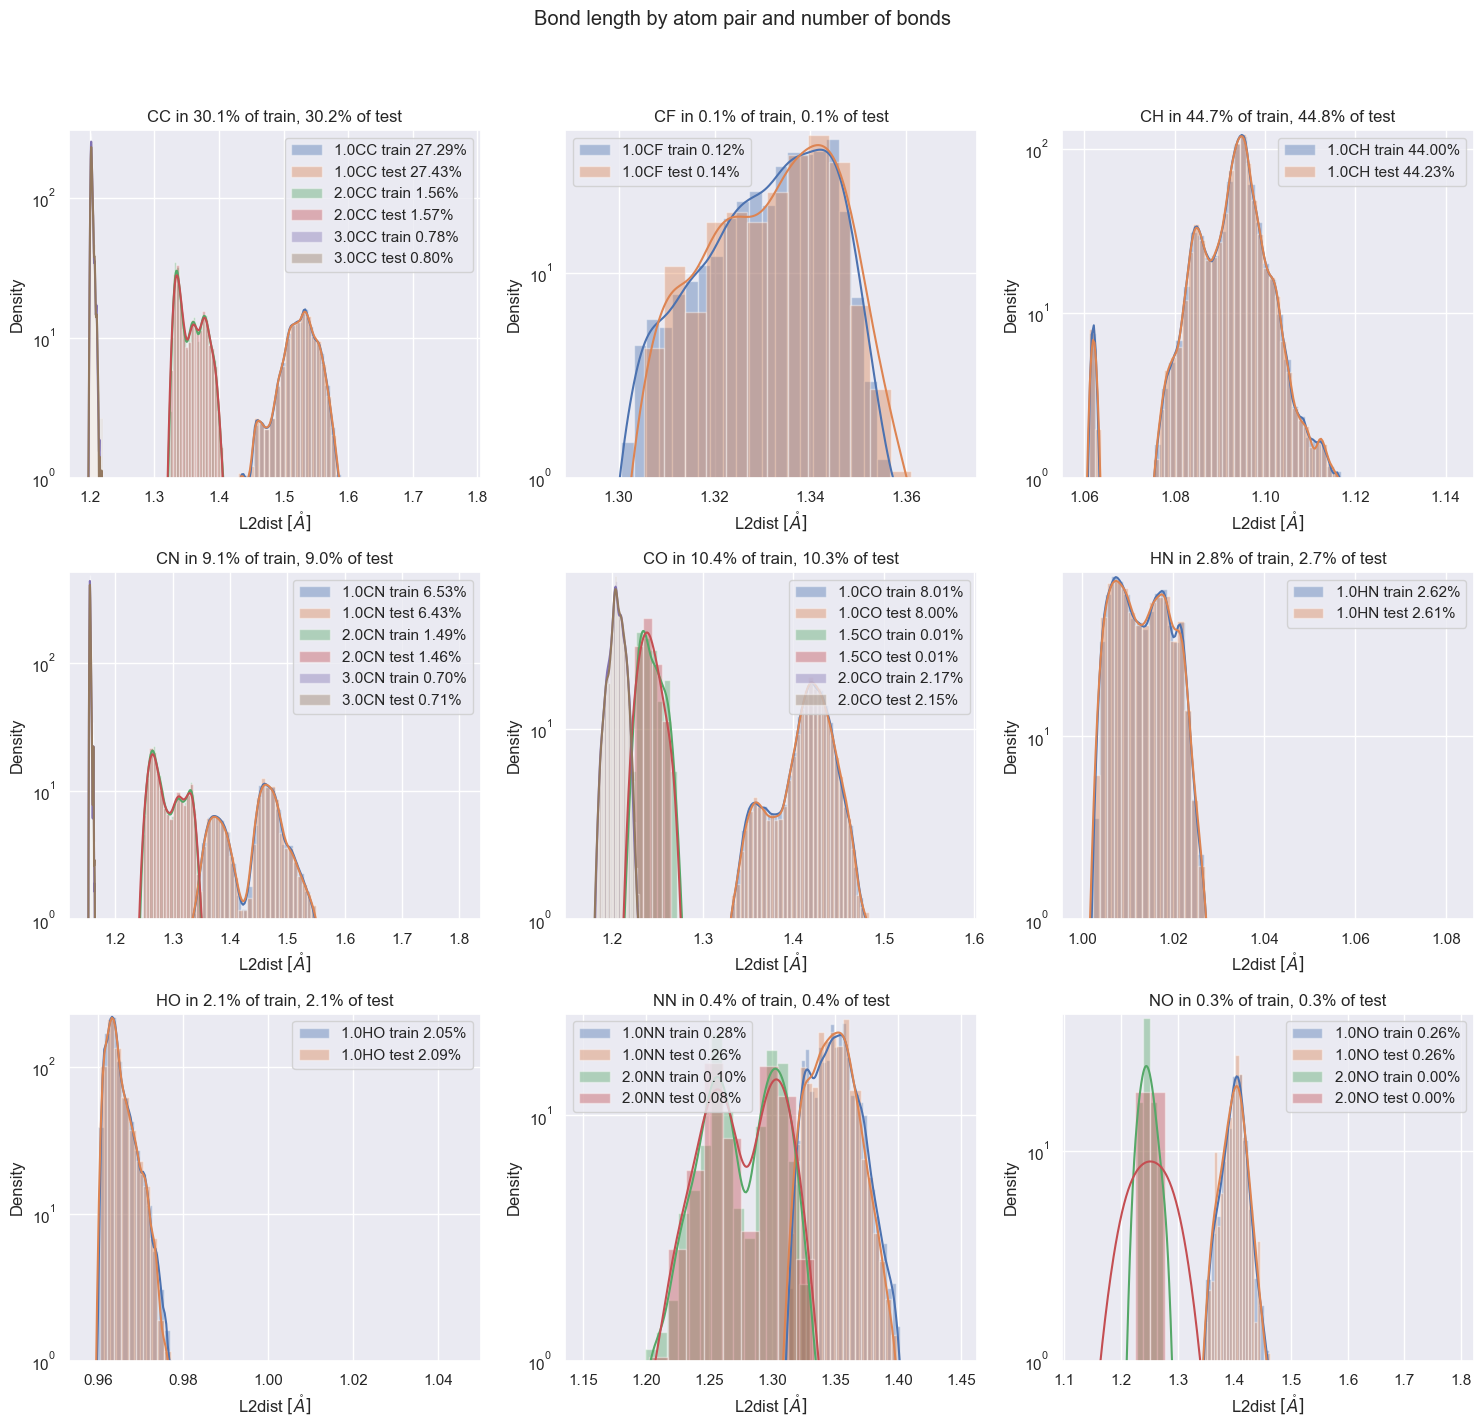

In [22]:
fig = plt.figure(figsize=(15,15))
bond_types = train_bonds.bond_type.unique()
unique_pairs = sorted({bond_type_to_pair(b):1 for b in bond_types}.keys())
print("Bond types: ", bond_types)
for (i, pair) in enumerate(unique_pairs):
    ax = fig.add_subplot(3, 3, i + 1)
    for bond_type in sorted([b for b in bond_types if pair == bond_type_to_pair(b)]):
        for (df, name) in [(train_bonds, "train"), (test_bonds, "test")]:
            #errors = df[(df.bond_type == bond_type) & (df.error == 1)].L2dist.values
            #if len(errors) > 0:
            #    sns.distplot(errors, color="red", kde=True)
            selection = df[(df.bond_type == bond_type) & (df.error == 0)].L2dist.values
            sns.distplot(selection, label=f"{bond_type} {name} {len(selection)/len(df)*100:.2f}%", kde=True, ax=ax)
    ax.set_ylim(1, ax.get_ylim()[1])
    ax.set_yscale('log')
    ax.set_xlabel("L2dist $[\mathring{A}]$")
    ratio_tr  = (train_bonds.bond_type.apply(bond_type_to_pair) == pair).sum() / len(train_bonds)
    ratio_tst = (test_bonds.bond_type.apply(bond_type_to_pair) == pair).sum() / len(test_bonds)
    ax.set_title(f"{pair} in {ratio_tr*100:.1f}% of train, {ratio_tst*100:.1f}% of test")
    ax.legend()
fig.suptitle("Bond length by atom pair and number of bonds")
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

/var/folders/yz/081kqsmd5n555rbq0gwqcrlc0000gn/T/ipykernel_76405/216221617.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ax.plot([float(m0.x), float(m1.x)],[float(m0.y), float(m1.y)],[float(m0.z), float(m1.z)],


TypeError: 'int' object is not subscriptable

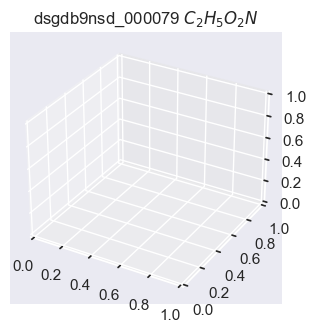

In [24]:
def select_range(df, l0, l1):
    return df[(df.bond_type == '1.0CN') & (df.error.values == 0) & (df.L2dist.values > l0) & (df.L2dist.values < l1)].molecule_name.unique()
peak1_molecules = select_range(train_bonds, 1.37, 1.375)
peak2_molecules = select_range(train_bonds, 1.465, 1.470)

ncols = 3
nrows = 3
fig1 = plt.figure(figsize = (18, 12))
for i in range(ncols*nrows):
    ax = fig1.add_subplot(nrows, ncols, i + 1, projection="3d")
    plot_molecule(peak1_molecules[i], bonds=train_bonds, charges=train_charges, ax=ax)
text = fig1.suptitle("molecules with 1CN from Peak 1")
fig1.tight_layout(rect=[0, 0.03, 1, 0.95])

In [25]:
train_bonds.to_csv(os.path.join(OUTPUT_PATH, "train_bonds.csv"), index=False)
test_bonds.to_csv(os.path.join(OUTPUT_PATH, "test_bonds.csv"), index=False)